# vMF-VAE modelling for new MCMCP (study2)

## What is von Mises-Fisher distribution?
> vMF is a kind of distribution over a (d-1)-dimentional hypersphere within a d-dimensional space, which could be a uniform distribution over the sphere, or a peak centered at any given vector \mu (with a parameter kappa controlling the variance). 

## Why I plan to replace the gaussian prior with von Mises-Fisher distribution?
* Origin gravity: Gaussian prior will push data towards the origin no matter what category it is;
> First, it makes no sense to encourage all categories to cluster in the center; then, this effect will cause imbalance distributions of different clusters, hindering the diversity of generation. 
* Hard to use uniform distribution in a hyper-plane space;
* vMF provide a grace solution to uniform facial affects, which could improve the representative ability of latent space;
* Emotions' distribution is theoretically 2-d with a potential Circumplex structure (Russell, 1980), lines up well with the vMF hypersphere;
* Put affect on 2-d manifold rather than 3-d space could ease both sampling process and space mapping.

## Why use 3-d latent space?
* I think we should stay with 3-d space (with 2-d sphere in it) because we need enough space to accomodate neutral and other faces, and also we can just estimate the density over the surface of hypersphere instead of the whole space where hypersphere is embedded in.

## What do the hyper-parameters mean and why to select specific values, like kappa particularly?
* The main concern in this model's training is to find a suitable kappa for 3-d vmf distribution which is big enough (the distribution become slimmer) for generator to learn face details (e.g., kappa=1 produces a generator that is able to generate an average face merely over the latent space, with a negative diversity, and hard to be seperated into different clusters as well --- high stickiness among the data), but also not too big to avoid reconstruting the facial identity information, making the model concentrate on the facial affect, and be continuous as well.
* Based on the current trials, k=300 with no matter how many epoches has the best performance.

## How much epochs do we need?
* Monitor the tendency of clustering in training, to determine when to terminate the training and guarantee the sparse distribution of the data.
* $collapse = \frac{\sum^{n-1}_{i=1}{\sum^{n}_{j=i}{distance(cluster_i, cluster_j)}}}{Within Cluster Distance}$
* collapse within [4, 5] is a good threshold to terminate the training;
* To guarantee the performance of decoder, after training I freeze the encoder and classifier and finetune the decoder for 20 epoches with 0.0001 learning rate;

## The vmf-VAE provides us a pure, continuous, finite facial-expression latent space, with good fidelity and diversity!
## The final question is, how to evaluate the model (not important but necessary) --- FID

In [1]:
import os
import gc
import numpy as np
import torch
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from train import train
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi

from dataset import get_dataloaders
import models
from utils import setup_seed, latent_space, manifold_sphere, reconstruction, EarlyStopping, latent_sample, identity_test, collapse_test, conditional_manifold

In [2]:
class config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # distribution_id = 'normal' # or normal
    distribution_emo = 'vmf' # or normal
    # latent_dim_id = 2  # determine shape of latent space, 2 or 3
    latent_dim_emo = 3  # determine shape of latent space, 2 or 3
    radius = 1.0  #controlling the radius of the hypersphere
    kappa = 300  # enough details but not too much, set as 500 according to the area of recontructive sampling

    data_path = "./data/cafe/balance_all"
    image_size = (64, 40)  # determine model layer size and data preprocessing: (40, 40) or (64, 40)
    label_list = {'0':'Neutral', '1':'Happy', '2':'Sad', '3':'Angry', '4':'Disgusted', '5':'Fear', '6':'Surprise'}

    weight_recon = 1
    # weight_class_id = 0  # weight of classfier loss
    weight_class_emo = 0
    
    aug = False
    Ncrop = False  # true only when aug is ture
    if Ncrop:
        batchsize = 16  # with Ncrop = 5
    elif not Ncrop:
        batchsize = 128
    else:
        raise NotImplemented
    
    loss = torch.nn.MSELoss  
    # "MSELoss" or "BCEWithLogitsLoss", when use BCEWithLogitsLoss, sigmoid af in the end of decoder should be removed!!
    n_epoch = 200
    learning_rate = 1e-3
    scheduler = None  # learning rate schedule, "reduce", None ...
    saved_path = "./saved_models/"

    # regularization = False  # deperacated
    # weight_regularization = 0
    
print(config.device)

cuda


In [3]:
# data
train_loader = get_dataloaders(path=config.data_path, bs=config.batchsize, augment=config.aug, input_size=config.image_size)

max value in image tensor is: tensor(0.7725)
size: torch.Size([64, 1, 64, 40])
tensor([[[0.2627, 0.3098, 0.3569,  ..., 0.2275, 0.2039, 0.1922],
         [0.3804, 0.4471, 0.4902,  ..., 0.2745, 0.2196, 0.1961],
         [0.4941, 0.5333, 0.5922,  ..., 0.3137, 0.2431, 0.1922],
         ...,
         [0.3882, 0.4235, 0.4157,  ..., 0.4275, 0.4353, 0.4588],
         [0.3804, 0.4275, 0.4196,  ..., 0.4353, 0.4471, 0.4510],
         [0.3647, 0.4353, 0.4196,  ..., 0.4392, 0.4471, 0.4549]]])


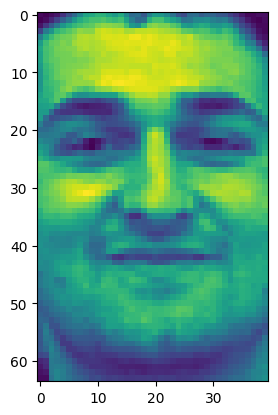

In [4]:
# show a case when augment is on
for i, data in enumerate(train_loader):
    if i==0 and config.aug and config.Ncrop:
        print('max value in image tensor is:', torch.max(data[0][0, 0, :, :]))
        print('size:', data[1].size())
        
        f, a = plt.subplots(1, 6)
        plt.setp(a.flat, xticks=[], yticks=[])
        a[0].imshow(data[0].cpu().numpy()[0, 0, :, :])
        for i in range(1, 6):
            a[i].imshow(data[1].cpu().numpy()[0, i-1, 0, :, :])
            
        print(data[2][0])

    elif i==0 and config.aug and config.Ncrop==False:
        print('max value in image tensor is:', torch.max(data[0][0, 0, :, :]))
        print('size:', data[1].size())
        
        f, a = plt.subplots(1, 2)
        plt.setp(a.flat, xticks=[], yticks=[])
        a[0].imshow(data[0].cpu().numpy()[0, 0, :, :])
        a[1].imshow(data[1].cpu().numpy()[0, 0, :, :])
            
        print(data[2][0])
        
    elif i==0 and config.aug==False and config.Ncrop==False:
        print('max value in image tensor is:', torch.max(data[0][0, 0, :, :]))
        print('size:', data[0].size())
        plt.imshow(data[0].cpu().numpy()[0, 0, :, :])
        print(data[1][0])

In [7]:
# model
model = models.conditionalVAE(z_dim_emo=config.latent_dim_emo,
                              size=config.image_size,
                              distribution_emo=config.distribution_emo, 
                              kappa=config.kappa, 
                              radius=config.radius, 
                              device=config.device).to(config.device)  
# default as vmf-VAE
summary(model, [(1,)+config.image_size, 1])

TypeError: Value after * must be an iterable, not int

In [9]:
print(model)

conditionalVAE(
  (cov_en0_emo): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_0_emo): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cov_en1_emo): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool_1_emo): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_en3_emo): Linear(in_features=2560, out_features=128, bias=True)
  (fc_mean_emo): Linear(in_features=128, out_features=3, bias=True)
  (fc_var_emo): Linear(in_features=128, out_features=1, bias=True)
  (fc_de0): Linear(in_features=4, out_features=128, bias=True)
  (fc_de1): Linear(in_features=128, out_features=2560, bias=True)
  (Tcov_de2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (Tcov_de3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (Tcov_de4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(

### training

In [12]:
for p in model.parameters():
    p.requires_grad = True
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

cov_en0_emo.weight
cov_en0_emo.bias
cov_en1_emo.weight
cov_en1_emo.bias
fc_en3_emo.weight
fc_en3_emo.bias
fc_mean_emo.weight
fc_mean_emo.bias
fc_var_emo.weight
fc_var_emo.bias
fc_de0.weight
fc_de0.bias
fc_de1.weight
fc_de1.bias
Tcov_de2.weight
Tcov_de2.bias
Tcov_de3.weight
Tcov_de3.bias
Tcov_de4.weight
Tcov_de4.bias
linear_emo.weight
linear_emo.bias


In [13]:
for i,p in enumerate(model.parameters()):
    if i > 19:
        p.requires_grad = False
print("The trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

The trainable parameters:
cov_en0_emo.weight
cov_en0_emo.bias
cov_en1_emo.weight
cov_en1_emo.bias
fc_en3_emo.weight
fc_en3_emo.bias
fc_mean_emo.weight
fc_mean_emo.bias
fc_var_emo.weight
fc_var_emo.bias
fc_de0.weight
fc_de0.bias
fc_de1.weight
fc_de1.bias
Tcov_de2.weight
Tcov_de2.bias
Tcov_de3.weight
Tcov_de3.bias
Tcov_de4.weight
Tcov_de4.bias


In [14]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# amp: automatic mixed precision training 
scaler = GradScaler()  
# scheduler to adjust the learning rate
if config.scheduler == 'reduce':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=False)

# training process trend monitor
# loss_reconstruction = []
# loss_classification = []
# collapse = []

# setup_seed(0)
for epoch in range(config.n_epoch):
    rec_loss, kl_loss, cla_loss = train(model, train_loader, optimizer, scaler, config, recon_target="emo")  # train_mode could be all, id, emo
    
    if config.scheduler == 'reduce':
        scheduler.step(rec_loss + cla_loss/250)

    print("Epoch%3d/%3d: RC_loss%8.3f, KL_loss%8.3f, CL_loss_emo%8.3f" 
          % (epoch+1, config.n_epoch, rec_loss, kl_loss, cla_loss))
    # print("=====XXX=====")

    # identity test
    # identity_ignore = identity_test(s_vae, train_loader, config)
    # print("identity ignore rate is:", identity_ignore)

    # collapse test
    # collapse_index = collapse_test(s_vae, train_loader, config)

    # training process trend monitor
    # loss_reconstruction.append(rec_loss.cpu().detach().numpy())
    # loss_classification.append(cla_loss.cpu().detach().numpy() / 250)
    # collapse.append(collapse_index)

    # if collapse_index > 4.3 and cla_loss <= 1680:  # the index is set as 4 based on the ideal ratio of within- and between-cluster distance
    #     break

    # finish the train
    if (epoch+1)%20 == 0:
        model_name = f"emo_{epoch+1}.pt"
        torch.save(model, config.saved_path + model_name)
        print("model has been saved as:", config.saved_path + model_name)

# training process trend monitor
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(loss_reconstruction, color='tab:blue', label="loss_reconstruction")
# ax.plot(loss_classification, color='tab:orange', label="loss_classification/250")
# ax.plot(collapse, color='tab:red', label="collapse")
# ax.vlines(len(loss_reconstruction)-config.finetune_epoch-1, 0, 10, linestyles='dashed', colors='yellow', label="start the decoder-finetune")
# plt.grid()
# plt.legend()
# plt.show()

Epoch  1/200: RC_loss   3.418, KL_loss  43.175, CL_loss_emo1871.574
Epoch  2/200: RC_loss   2.867, KL_loss  43.175, CL_loss_emo1871.860
Epoch  3/200: RC_loss   2.727, KL_loss  43.175, CL_loss_emo1871.642
Epoch  4/200: RC_loss   2.613, KL_loss  43.175, CL_loss_emo1871.665
Epoch  5/200: RC_loss   2.506, KL_loss  43.175, CL_loss_emo1872.386
Epoch  6/200: RC_loss   2.430, KL_loss  43.175, CL_loss_emo1872.219
Epoch  7/200: RC_loss   2.333, KL_loss  43.175, CL_loss_emo1872.484
Epoch  8/200: RC_loss   2.268, KL_loss  43.175, CL_loss_emo1872.782
Epoch  9/200: RC_loss   2.214, KL_loss  43.175, CL_loss_emo1872.748
Epoch 10/200: RC_loss   2.150, KL_loss  43.175, CL_loss_emo1872.542
Epoch 11/200: RC_loss   2.098, KL_loss  43.175, CL_loss_emo1873.204
Epoch 12/200: RC_loss   2.082, KL_loss  43.175, CL_loss_emo1873.567
Epoch 13/200: RC_loss   2.049, KL_loss  43.175, CL_loss_emo1873.614
Epoch 14/200: RC_loss   2.029, KL_loss  43.175, CL_loss_emo1873.897
Epoch 15/200: RC_loss   2.021, KL_loss  43.175, 

### vasualization

In [4]:
model_name = "emo_200.pt"  # "k30_e50, k35_e50, k35_e50(2d), k35_e80(2d), k35_e80_w3(2d), k35_e80_w3(2d_40x40), k40_e80, k300_e50_v2"
model = torch.load(config.saved_path + model_name)
%matplotlib widget 

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'hypersphere.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Number of data: 960


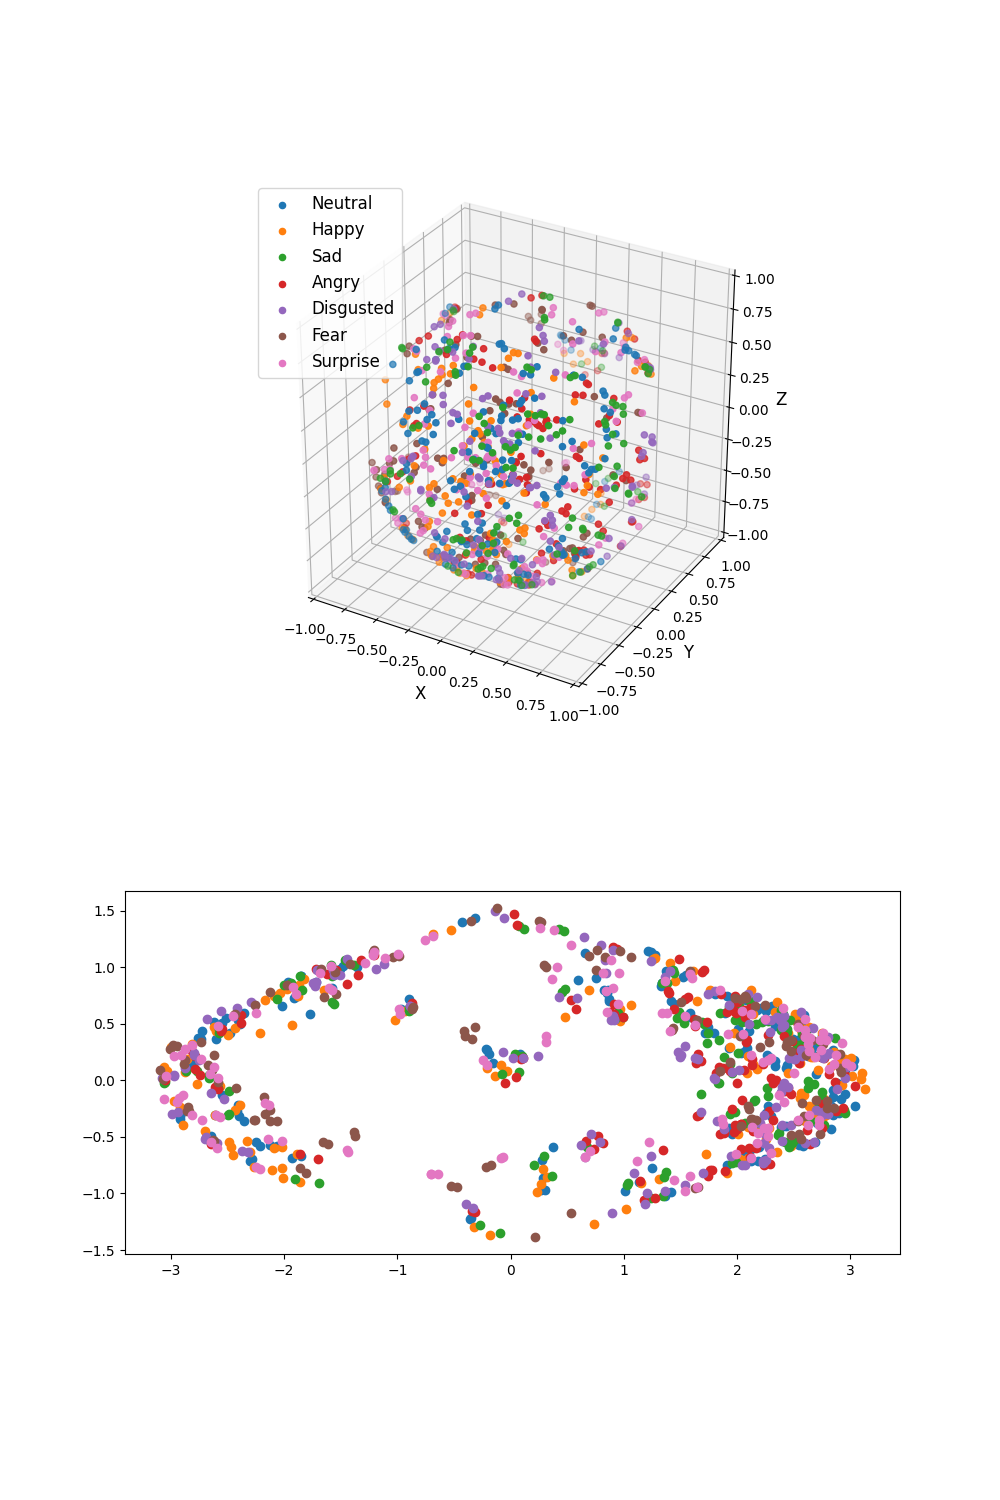

In [6]:
latent_space(model, train_loader, config, legend=True)

In [20]:
plt.close()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x6 and 5x128)

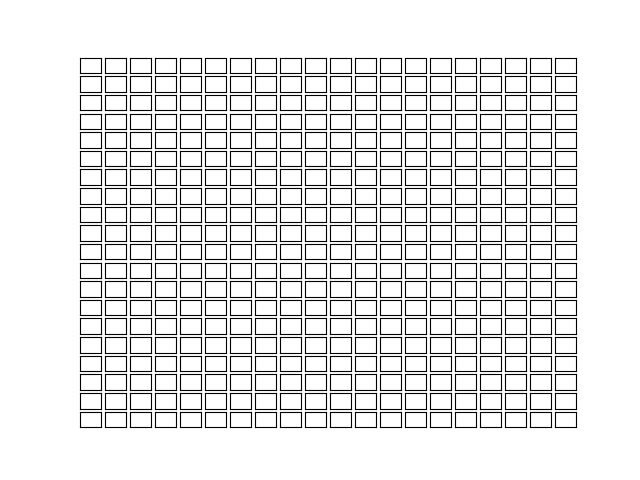

In [30]:
xy_resolution = 20
manifold_sphere(model, "emo", config, 
                theta=list(b*pi for b in np.linspace(0, 2, xy_resolution)), 
                z_resolution=20, # z_resolution works only when z_dim=3
               )  # theta belons to the range 0-2pi

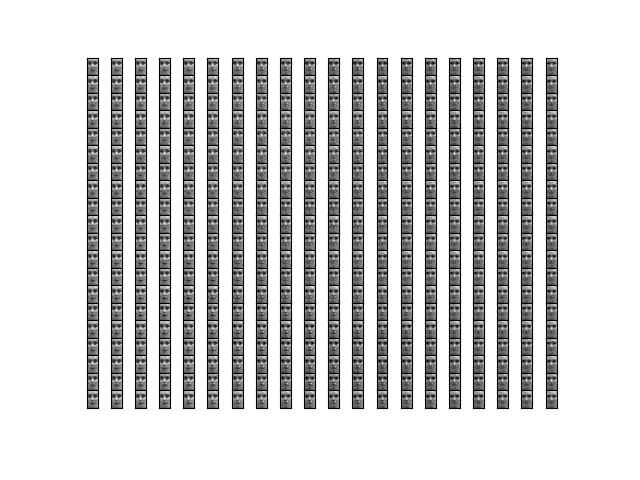

In [54]:
xy_resolution = 20
conditional_manifold(model, "emo", torch.tensor([[5.6, -9.3]]), config, 
                theta=list(b*pi for b in np.linspace(0, 2, xy_resolution)), 
                z_resolution=20, # z_resolution works only when z_dim=3
               )  # theta belons to the range 0-2pi

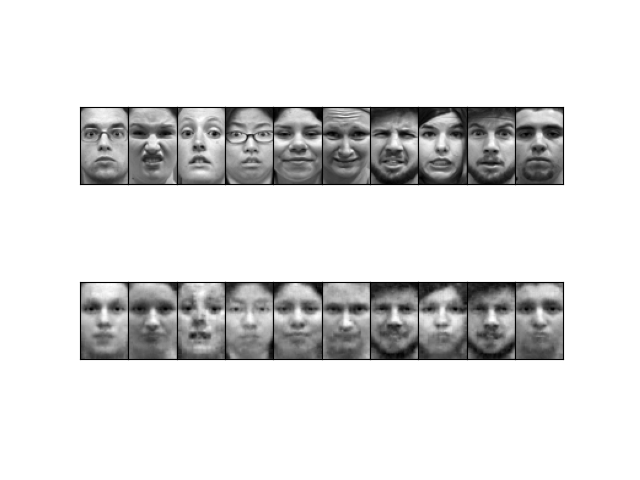

In [15]:
reconstruction(model, train_loader, n_show=10, config=config)

In [ ]:
len(train_loader)

In [10]:
latent_sample(model, config)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x3 and 6x128)

In [13]:
from hypersphere.distributions import VonMisesFisher
%matplotlib widget 

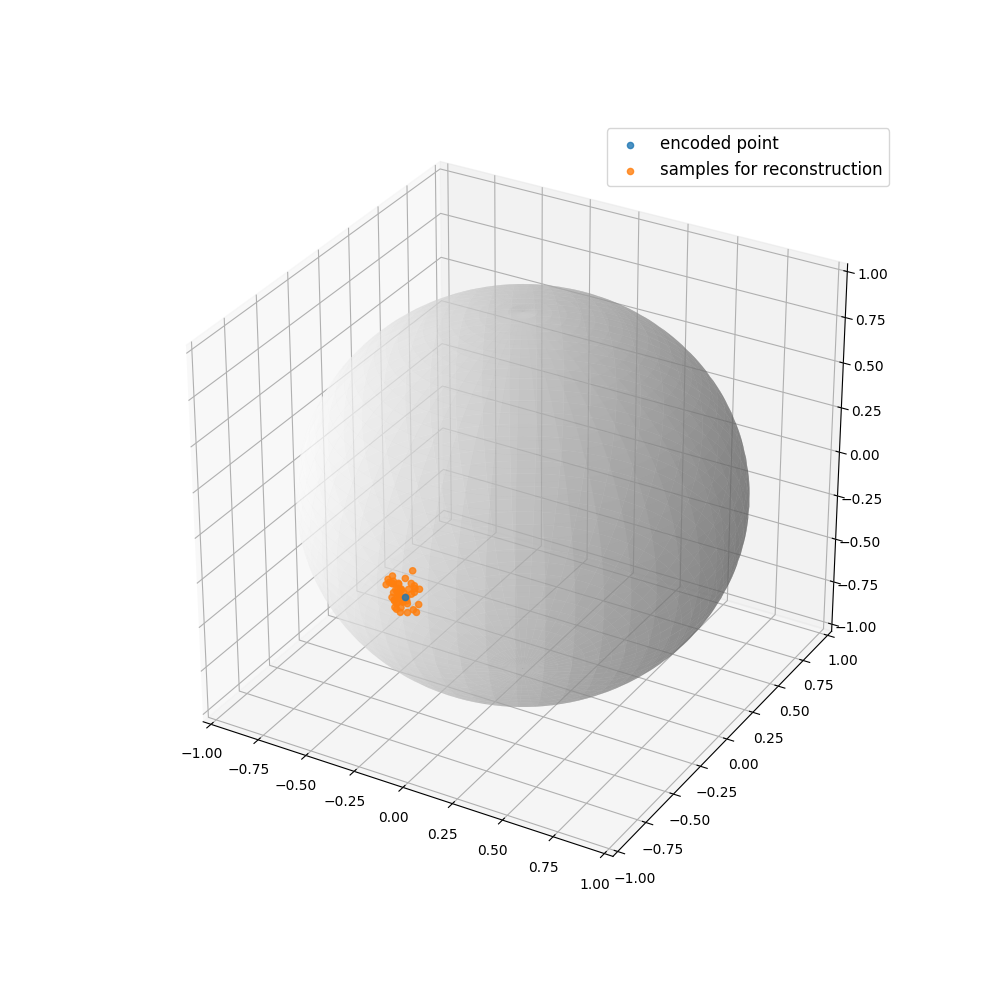

In [16]:
center = torch.tensor([[0, -1, 0]], dtype=torch.float64)
sampler = VonMisesFisher(center, torch.tensor([[1]], dtype=torch.float64), k=500)
samples = sampler.rsample(50)[:, 0, :]
# print(samples)
ax = plt.figure(figsize=(10, 10)).add_subplot(111, projection='3d', computed_zorder=False)

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, zorder=-1, alpha=0.5, color="white")
# Set an equal aspect ratio
ax.set_aspect('equal')

ax.scatter(center[0, 0],
           center[0, 1],
           center[0, 2],
           alpha=0.8, label="encoded point", zorder=999)
ax.scatter(samples[:, 0],
           samples[:, 1],
           samples[:, 2],
           alpha=0.8, label="samples for reconstruction")

ax.legend(fontsize=12)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.show()

In [ ]:
plt.close()

In [23]:
from math import pi, atan2, asin, sqrt
import numpy as np